# Estimating expressibility of quantum circuits

The method here presented is based on the proposed expressibility descriptor of [Expressibility and Entangling Capability of Parameterized Quantum Circuits for Hybrid Quantum-Classical Algorithms - S. Sim, P. D. Johnson, A. Aspuru-Guzik, 2019]. The main idea is to estimate the histogram related to fidelities distribution comparing the states produced by the circuit and compare with the distribution obtained via the induced Haar measure on the space of states (here, pure states only).

Firstly, the circuit fidelities are going to be calculated using the well-known formula: $F(\rho(\theta),\sigma(\omega)) := |<\psi_{\theta}|\phi_{\omega}>|^2$, where the vector states are the correspondents to the density matrix pure states. This is going to be sampled a certain number of times with the states obtained by the circuit.

Secondly, we are going to compare the values with the histogram obtained via the induced Haar measure. We have an analytical expression to the probability density function (PDF) of fidelities for Haar random pure states, obtained uniformly sampling with the Fubini-Study metric induced measure: $p_{Haar}(F) = (N-1)(1-F)^{N-2}$, where $F$ is the fidelity value and $N$ is the dimension of the Hilbert space. Later, we are going to obtain the corresponding histogram.

Finally, we compare both histograms using the Kullback-Leibler divergence a.k.a. relative entropy. The so-obtained value quantifies how much the state sampling of the circuit is different from the uniformly drawn Haar random distribution. The specific formula is read as: $D_{KL}(P|Q) = \sum_i P(i) log(\frac{P(i)}{Q(i)})$.

We start to tackle the problem defining the circuit.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.special import rel_entr

#np.random.seed(42)

In [2]:
wires = 1 #number of qubits
dev = qml.device("default.qubit", wires=wires, shots=None)

In [3]:
def test_ansatz(rots):
#    for i in range(wires):
#        qml.RY(rots[i], wires=[i])
#    qml.broadcast(qml.CNOT, wires=range(wires), pattern="chain")
    qml.Hadamard(wires=[0])
    qml.RZ(rots[0], wires=[0])
    qml.RY(rots[1], wires=[0])
    return qml.state()

test_circuit = qml.QNode(test_ansatz, dev)

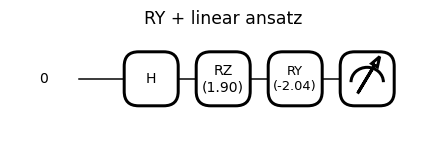

In [4]:
#angles = np.array([np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
#                     requires_grad=True)

angles = np.array([np.random.uniform(low=-np.pi, high=np.pi) for i in range(2)],
                     requires_grad=True)

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(test_circuit, decimals=2)(angles)
fig1.suptitle("RY + linear ansatz", fontsize='xx-large')
plt.show()

# Calculating fidelities for a definite number of samples

We now build a function that is going the take as input parameters the circuit and number of samples (notice that this number is the number of fidelities calculated, therefore the number of states needed is 2x the number of samples)

In [5]:
def fidel_histogram(binsnumb, samples, circuit):
    fidel_vector = []
    for i in range(samples):
        #angles1 = np.array([np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
        #             requires_grad=True)
        #angles2 = np.array([np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
        #             requires_grad=True)
        
        angles1 = np.array([np.random.uniform(low=-np.pi, high=np.pi) for i in range(2)],
                     requires_grad=True)
        angles2 = np.array([np.random.uniform(low=-np.pi, high=np.pi) for i in range(2)],
                     requires_grad=True)
        
        state1 = circuit(angles1)
        state2 = circuit(angles2)
        
        F = np.abs( np.dot(state1, state2) )**2
        
        fidel_vector.append(F)
        
    fidel_vector = np.asarray(fidel_vector)
    
    binsize = 1.0/binsnumb
    bins = np.arange(0, 1. + binsize, binsize)
    
    histogram, bins = np.histogram(fidel_vector, bins=bins)[0]/samples, np.histogram(fidel_vector, bins=bins)[1]
    
    return histogram, bins

In [6]:
samplesize = 10000
nbins = 75
width = 1.0/nbins

hist, bins = fidel_histogram(nbins, samplesize, test_circuit)

In [7]:
print(sum(hist))

0.9999999999999999


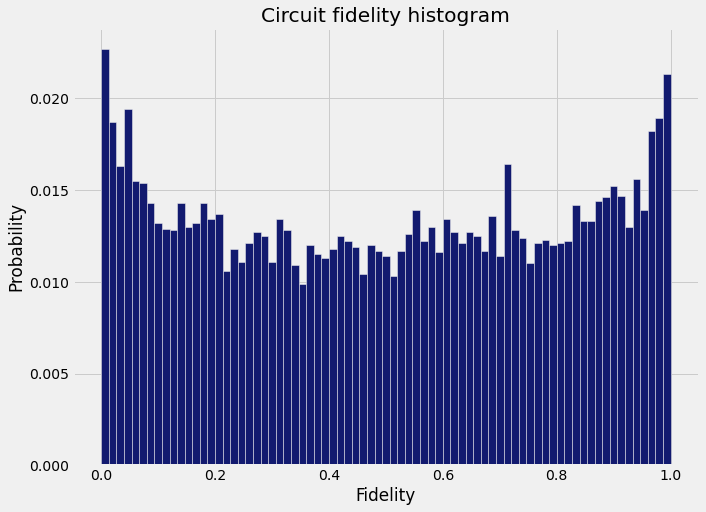

In [8]:
#Just for the appearance
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize = (10, 7.5))
ax = fig.add_subplot(111)

ax.bar(bins[:-1]+width/2, hist, color = '#121A6F', width = width)

ax.title.set_text('Circuit fidelity histogram')
ax.set_xlabel('Fidelity')
ax.set_ylabel('Probability')

plt.show()

Now that we have the corresponding circuit histogram, we can sample over the Haar ensemble and compare the two distributions.

# The Haar distributed fidelities

We're going to sample according to the analytical expression: $p_{Haar}(F) = (N-1)(1-F)^{N-2}$, where $F$ is the fidelity value and $N$ is the dimension of the Hilbert space. To transform this into an histogram, we can integrated this PDF over the edges of each bin, i.e.:

$P_{Haar}(x,y) = \int_x^y (N-1)(1-F)^{N-2} dF = (1-y)^{N-1} - (1-x)^{N-1}$

This way, the desired histogram is obtained associating to each bin the total probability calculated with upper edge equal to y and lower edge equal to x. The associated number and size of bins has to be tha same of the circuit case, so the histograms are comparable. This is going to be the next procedure:

In [9]:
N = 2**wires #dimension of the Hilbert space

histogram_Haar = []

for i in range(nbins):
    histogram_Haar.append(  (1-bins[i])**(N-1) - (1-bins[i+1])**(N-1)  )

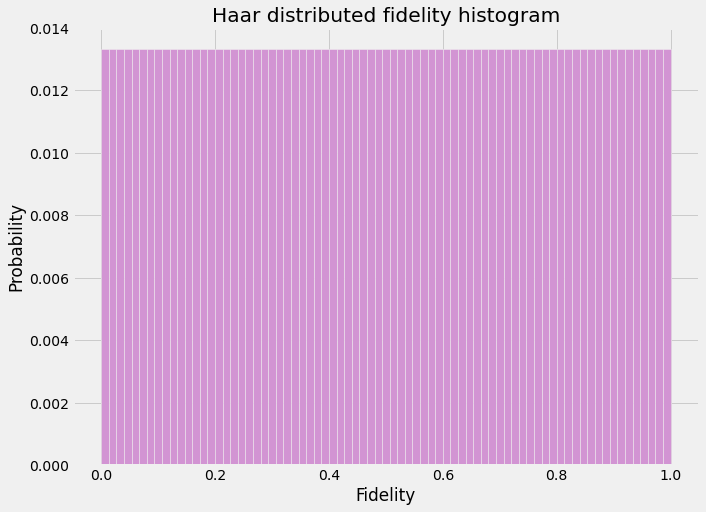

In [10]:
fig = plt.figure(figsize = (10, 7.5))
ax = fig.add_subplot(111)

ax.bar(bins[:-1] + width/2, histogram_Haar, color = '#D294D3', width = width)

ax.title.set_text('Haar distributed fidelity histogram')
ax.set_xlabel('Fidelity')
ax.set_ylabel('Probability')

plt.show()

We can compare the obtained histograms plotting side to side:

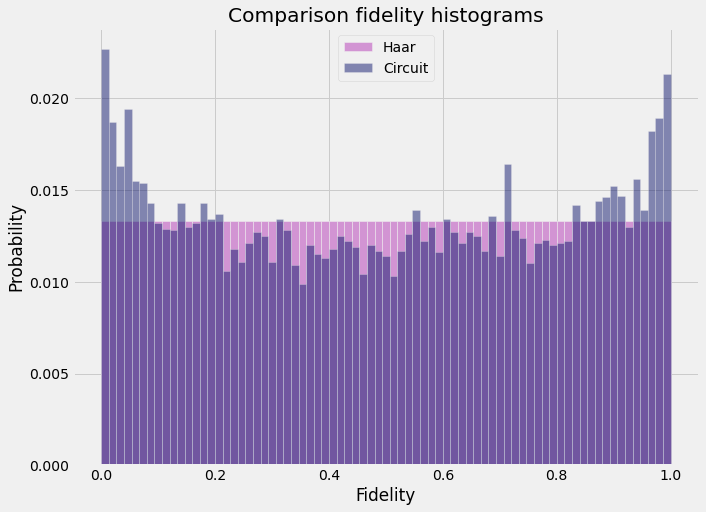

In [11]:
fig = plt.figure(figsize = (10, 7.5))
ax = fig.add_subplot(111)

ax.bar(bins[:-1] + width/2, histogram_Haar, width = width, color = '#D294D3', label = 'Haar')
ax.bar(bins[:-1] + width/2, hist, width = width, alpha = 0.5, color = '#121A6F', label = 'Circuit')

# Color inspiration: https://t3.ftcdn.net/jpg/02/34/22/62/360_F_234226207_0nZlnHxQ2xbRZr3EXbjA5jJruq93VHfM.jpg


ax.title.set_text('Comparison fidelity histograms')
ax.set_xlabel('Fidelity')
ax.set_ylabel('Probability')
ax.legend()

plt.show()

# Estimating expressibility comparing histograms

To obtain expressibility quantifier, we compute the "differences" between the distributions via the Kullback-Leibler divergence a.k.a. the relative entropy. There is a built-in function of scipy named rel_entr that calculates each of the terms in the sum, $P(i)log(\frac{P(i)}{Q(i)})$, and joint as an array. After this, we compute the sum to estimate the relative entropy explicitly.

In [12]:
D_KL = rel_entr(hist, histogram_Haar)

In [13]:
print('Relative entropy S(Empir||Haar) = %.3f nats' % sum(D_KL))

Relative entropy S(Empir||Haar) = 0.015 nats
